In [1]:
#lets start with some imports

import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop

import operator

import xarray as xr
import netCDF4

import scipy.ndimage as ndimage

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy
import matplotlib.colors as mc
import matplotlib.ticker as mt
import matplotlib.font_manager as fm
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Setup
### Config files

In [2]:
meta_config = config.get_metadata('cacti_csapr2_ppi')
cmac_config = config.get_cmac_values('cacti_csapr2_ppi')
field_config = config.get_field_names('cacti_csapr2_ppi')


temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

#field_config['reflectivity'] = 'uncorrected_reflectivity_h'
#field_config['phidp'] = 'uncorrected_differential_phase'

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']

### Constants

In [3]:
verbose = True
sweep = 2

### Paths

In [4]:
# on bebop
# soundings_directory = '/data/CACTI/sonde/'
# radar_directory = '/data/CACTI/csapr2/'

# on STRATUS
radar_directory = '/lustre/or-hydra/cades-arm/proj-shared/corcsapr2cfrppiM1.a1/201901/'
soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/corsondewnpnM1.b1/'

### Read test file/s

First, read the radar file. The file is read into the `radar` object.

In [5]:
inf = 'corcsapr2cfrppiM1.a1.20190124.200003.nc'
radar = pyart.io.read(radar_directory + inf)


Then read the sounding file that corresponds to the radar file.

In [6]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'corsondewnpnM1.b1.20190124.210000.cdf')

Investigate the radar object by printing keys and what they mean.

In [7]:
for key in radar.fields.keys():
    print(key+' : '+radar.fields[key]['long_name'])

attenuation_corrected_differential_reflectivity : Rainfall attenuation-corrected differential reflectivity
attenuation_corrected_differential_reflectivity_lag_1 : Differential reflectivity estimated at lag 1 corrected for rainfall attenuation.
attenuation_corrected_reflectivity_h : Rainfall attenuation-corrected reflectivity, horizontal channel
censor_mask : Censor Mask
classification_mask : Classification Mask
copol_correlation_coeff : Copolar correlation coefficient (also known as rhohv)
differential_phase : Differential propagation phase shift
differential_reflectivity : Differential reflectivity
differential_reflectivity_lag_1 : Differential reflectivity estimated at lag 1
mean_doppler_velocity : Radial mean Doppler velocity, positive for motion away from the instrument
mean_doppler_velocity_v : Doppler velocity, vertical channel
normalized_coherent_power : Normalized coherent power, also known as SQI.
normalized_coherent_power_v : Normalized coherent power, also known as SQI, Vert

# Prepare the data by applying offsets, if any
### Flip PhiDP?

In [8]:
if cmac_config['flip_phidp']:
    for fld in cmac_config['phidp_flipped']:
        radar.fields[fld]['data'] = radar.fields[fld]['data']*-1.0
        

### ZDR offset

In [9]:
if 'zdr_offset' in cmac_config.keys():
    if 'offset_zdrs' in cmac_config.keys():
        for fld in cmac_config['offset_zdrs']:
            radar.fields[fld]['data'] += cmac_config['zdr_offset']
    else:
        radar.fields[field_config['input_zdr']]['data'] += cmac_config['zdr_offset']


# Generate clutter file

If config file doesn't say to generate clutter from reflectivity, set `gen_clutter_from_refl` flag to False.

If config file says to generate clutter from reflectivity, then generate clutter field from reflectivity and add it to the radar object.

In [10]:
if 'gen_clutter_from_refl' not in cmac_config.keys():
    cmac_config['gen_clutter_from_refl'] = False

if cmac_config['gen_clutter_from_refl']:
    new_clutter_field = cmac_processing.gen_clutter_field_from_refl(radar, 
                                                                    field_config['input_clutter_corrected_reflectivity'],
                                                                    field_config['reflectivity'],
                                                                    diff_dbz=cmac_config['gen_clutter_from_refl_diff'], 
                                                                    max_h=cmac_config['gen_clutter_from_refl_alt'])
    radar.add_field(field_config['clutter'], new_clutter_field, replace_existing=True)
                                 
                                 

# Extract location and time of file

In [11]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('America/Cordoba')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = '%.1f' % radar.fixed_angle['data'][sweep] + ' Degree sweep ' +local_time.strftime('%A %B %d at %I:%M %p GMT%Z')
print(fancy_date_string)

2.6 Degree sweep Thursday January 24 at 05:00 PM GMT-03


# First, look at uncorrected reflectivity

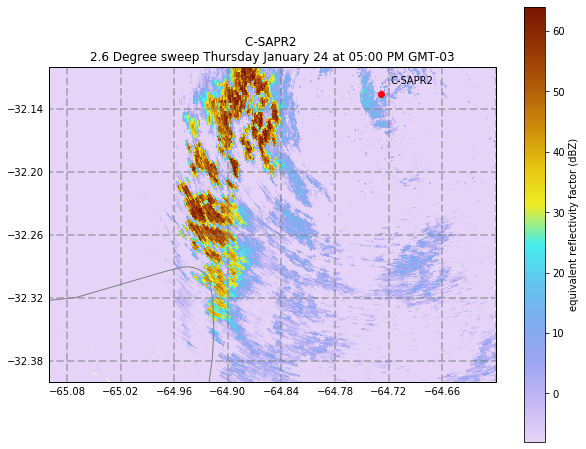

In [12]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'uncorrected_reflectivity_h', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


Clutter is very present in some areas.

But we will continue to use the raw (uncorrected) reflectivity, because later on we will use the gatefilter to exclude clutter-contaminated gates.

# Calculate dual-pol moments

### Get velocity texture

In [13]:
if 'clutter_mask_z_for_texture' not in cmac_config.keys():
        cmac_config['clutter_mask_z_for_texture'] = False

if cmac_config['clutter_mask_z_for_texture']:
    masked_vr = copy.deepcopy(radar.fields[vel_field])
    masked_vr['data'] = np.ma.masked_where(radar.fields['ground_clutter']['data'] == 1, masked_vr['data'])
    masked_vr['data'][radar.fields['ground_clutter']['data'] == 1] = np.nan
    radar.add_field('clutter_masked_velocity', masked_vr, replace_existing=True)

    texture = cmac_processing.get_texture(radar, 'clutter_masked_velocity')
    texture['data'][np.isnan(texture['data'])] = 0.0
else:
    texture = cmac_processing.get_texture(radar, vel_field)

### Get sounding temperature, height, signal-to-noise-ratio (snr)

Map altitude and temperature to radar gates.
Calculate signal-to-noise-ratio from reflectivity.

In [14]:
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(ncf_sounding.variables[temp_field][:], 
                                                        ncf_sounding.variables[alt_field][:], 
                                                        radar)


snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)

### Add new fields to the radar object

In [15]:
radar.add_field('sounding_temperature', temp_dict, replace_existing=True)
radar.add_field('height', z_dict, replace_existing=True)
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
radar.add_field('velocity_texture', texture, replace_existing=True)


### Fuzzy echo classification

In [16]:
rhv_field = field_config['cross_correlation_ratio']
ncp_field = field_config['normalized_coherent_power']

if 'mbfs' not in cmac_config:
    cmac_config['mbfs'] = None

if 'hard_const' not in cmac_config:
    cmac_config['hard_const'] = None


my_fuzz, _ = cmac_processing.do_my_fuzz(radar, rhv_field, ncp_field, tex_start=4.,
                        tex_end=5., 
                        custom_mbfs=cmac_config['mbfs'],
                        custom_hard_constraints=cmac_config['hard_const'],
                        verbose=True)

radar.add_field('gate_id', my_fuzz,
                replace_existing=True)

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5401, 5401, 5401]), array([ 0,  1,  2, ..., 49, 50, 51]))
##    Doing hard constraining multi_trip
##     (array([1440, 1440, 1440, ..., 5401, 5401, 5401]), array([ 987,  988,  989, ..., 1097, 1098, 1099]))
##    Doing hard constraining melting
##     (array([ 720,  720,  720, ..., 5401, 5401, 5401]), array([1046, 1047, 1048, ..., 1097, 1098, 1099]))
##    Doing hard constraining rain
##     (array([ 721,  721,  721, ..., 5401, 5401, 5401]), array([1069, 1070, 1071, ...,  513,  514,  515]))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 5401, 5401, 5401]), array([ 244,  245,  246, ..., 1097, 1098, 1099]))
2


Add clutter map in the gate_id dictionary.

In [17]:
if 'ground_clutter' in radar.fields.keys():
    # Adding fifth gate id, clutter.
    clutter_data = radar.fields['ground_clutter']['data']
    gate_data = radar.fields['gate_id']['data']
    radar.fields['gate_id']['data'][clutter_data == 1] = 5
    notes = radar.fields['gate_id']['notes']
    radar.fields['gate_id']['notes'] = notes + ',5:clutter'
    radar.fields['gate_id']['valid_max'] = 5
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    cat_dict.update(
        {pair_str.split(':')[1]:int(pair_str.split(':')[0])})

if verbose:
    print('##    gate_id')

##    gate_id


In [18]:
cat_dict

{'multi_trip': 0,
 'rain': 1,
 'snow': 2,
 'no_scatter': 3,
 'melting': 4,
 'clutter': 5}

In [19]:
cmac_gates = pyart.correct.GateFilter(radar)
cmac_gates.exclude_all()
cmac_gates.include_equal('gate_id', cat_dict['rain'])
cmac_gates.include_equal('gate_id', cat_dict['melting'])
cmac_gates.include_equal('gate_id', cat_dict['snow'])


### Create a simulated velocity field from the sonde object

In [20]:
#Bug: need to fix
radar.gate_altitude['data'] = radar.gate_altitude['data'].data

# Create a simulated velocity field from the sonde object.
u_field = field_config['u_wind']
v_field = field_config['v_wind']
u_wind = ncf_sounding.variables[u_field][:]
v_wind = ncf_sounding.variables[v_field][:]
alt_field = field_config['altitude']
sonde_alt = ncf_sounding.variables[alt_field][:]
profile = pyart.core.HorizontalWindProfile.from_u_and_v(
    sonde_alt, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, profile)
radar.add_field('simulated_velocity', sim_vel, replace_existing=True)


### Calculated corrected velocity 

Some outputs will appear in the terminal, related to the variational dealiaser (by Bobby). This cell takes a bit of time to run.

In [21]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field=vel_field, ref_vel_field='simulated_velocity',
    keep_original=False, gatefilter=cmac_gates, centered=True)

radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

print('##    corrected_velocity')
print('##    simulated_velocity')

fzl = cmac_processing.get_melt(radar) ### freezing level


##    corrected_velocity
##    simulated_velocity
5448.0


### Calculating differential phase fields

In [22]:

# Calculating differential phase fields.
phidp, kdp = pyart.correct.phase_proc_lp_gf(
    radar, gatefilter=cmac_gates, offset=ref_offset, debug=True,
    nowrap=50, fzl=fzl, self_const=self_const, phidp_field=field_config['input_phidp_field'])
phidp_filt, kdp_filt = cmac_processing.fix_phase_fields(
    copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
    cmac_gates)

radar.add_field('corrected_differential_phase', phidp,
                replace_existing=True)
radar.add_field('filtered_corrected_differential_phase', phidp_filt,
                replace_existing=True)
radar.add_field('corrected_specific_diff_phase', kdp,
                replace_existing=True)
radar.add_field('filtered_corrected_specific_diff_phase', kdp_filt,
                replace_existing=True)

print('##    corrected_specific_diff_phase')
print('##    filtered_corrected_specific_diff_phase')
print('##    corrected_differential_phase')
print('##    filtered_corrected_differential_phase')

Unfolding
Exec time:  4.926535129547119
Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
(5402, 1099)
(5402, 1100)
##    corrected_specific_diff_phase
##    filtered_corrected_specific_diff_phase
##    corrected_differential_phase
##    filtered_corrected_differential_phase


# Retrieve rainfall using R(A)

### Calculate attenuation

In [23]:
# Calculating attenuation by using pyart.
refl_field = field_config['reflectivity']
attenuation_a_coef = cmac_config['attenuation_a_coef']
c_coef = cmac_config['c_coef']
d_coef = cmac_config['d_coef']
beta_coef = cmac_config['beta_coef']
zdr_field = field_config['input_zdr']

In [24]:
radar.fields['corrected_differential_reflectivity'] = copy.deepcopy(
    radar.fields[zdr_field])
radar.fields['corrected_reflectivity'] = copy.deepcopy(
    radar.fields[refl_field])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_where(
    cmac_gates.gate_excluded,
    radar.fields['corrected_reflectivity']['data'])

# Get specific differential attenuation.
# Need height over 0C isobar.
iso0 = np.ma.mean(radar.fields['height']['data'][
    np.where(np.abs(radar.fields['sounding_temperature']['data']) < 0.1)])
radar.fields['height_over_iso0'] = copy.deepcopy(radar.fields['height'])
radar.fields['height_over_iso0']['data'] -= iso0

In [25]:
(spec_at, pia_dict, cor_z, spec_diff_at,
 pida_dict, cor_zdr) = pyart.correct.calculate_attenuation_zphi(
     radar, temp_field='sounding_temperature',
     iso0_field='height_over_iso0',
     zdr_field='corrected_differential_reflectivity',
     pia_field='path_integrated_attenuation',
     refl_field=field_config['reflectivity'], 
     c=c_coef, d=d_coef,
     a_coef=attenuation_a_coef, beta=beta_coef,
     phidp_field='filtered_corrected_differential_phase')
cor_zdr['data'] += cmac_config['zdr_offset']
radar.add_field('specific_attenuation', spec_at, replace_existing=True)
radar.add_field('path_integrated_attenuation', pia_dict,
                replace_existing=True)
radar.add_field('corrected_reflectivity', cor_z, replace_existing=True)
radar.add_field('specific_differential_attenuation', spec_diff_at,
                replace_existing=True)
radar.add_field('path_integrated_differential_attenuation', pida_dict,
                replace_existing=True)
radar.add_field('corrected_differential_reflectivity', cor_zdr,
                replace_existing=True)


### Plot specific attenuation

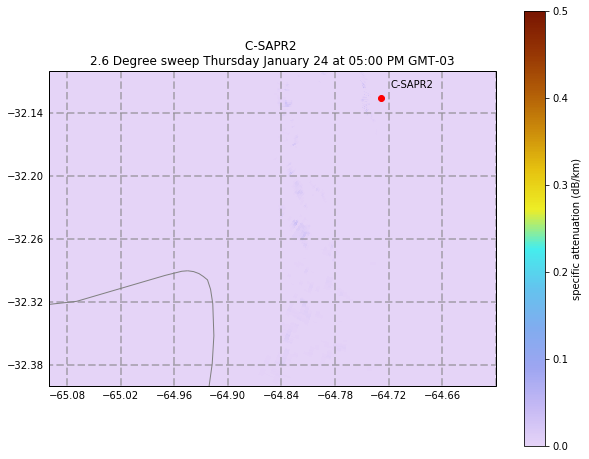

In [26]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'specific_attenuation', 0, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=0.5, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


### Calculate rain rate from attenuation : R(A)

The parameters for R(A) comes from https://journals.ametsoc.org/doi/pdf/10.1175/JAMC-D-13-0321.1

Giangrande et al. (2014) Precipitation Estimation from the ARM Distributed Radar Network during the MC3E Campaign

In [27]:
# Calculating rain rate.
R = 294.* (radar.fields['specific_attenuation']['data']) ** 0.89

# Create rain rate field
rainrate = copy.deepcopy(radar.fields['specific_attenuation'])
rainrate['data'] = R
rainrate['valid_min'] = 0.0
rainrate['valid_max'] = 400.0
rainrate['standard_name'] = 'rainfall_rate'
rainrate['long_name'] = 'rainfall_rate'
rainrate['least_significant_digit'] = 1
rainrate['units'] = 'mm/hr'
radar.fields.update({'rain_rate_A': rainrate})

# This needs to be updated to a gatefilter.
mask = radar.fields['reflectivity']['data'].mask

radar.fields['rain_rate_A']['data'][np.where(mask)] = 0.0
radar.fields['rain_rate_A'].update({
    'comment': ('Rain rate calculated from specific_attenuation,',
                ' R=51.3*specific_attenuation**0.81, note R=0.0 where',
                ' norm coherent power < 0.4 or rhohv < 0.8')})

if verbose:
    print('## Rainfall rate as a function of A ##')

print('##')
print('## All CMAC fields have been added to the radar object.')
print('##')

## Rainfall rate as a function of A ##
##
## All CMAC fields have been added to the radar object.
##


In [28]:
clutter = pyart.filters.GateFilter(radar)
clutter.exclude_equal('gate_id', cat_dict['clutter'])


### Plot R(A)

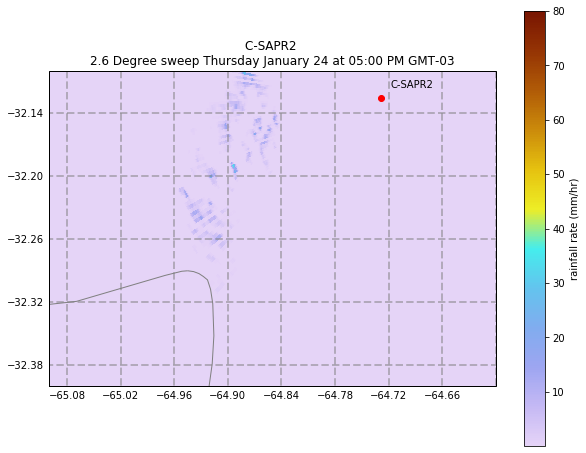

In [29]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_rate_A', 2, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0.1, vmax=80, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1)

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
